# **0. Imports**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [97]:
##pd.set_option('display.float_format', lambda x: '%.2f' % x)
#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    
#    plt.style.use( 'ggplot')
#    plt.rcParams['figure.figsize'] = [16, 9]
#    plt.rcParams['font.size'] = 24
#    
#    #display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    
#    sns.set()
#    
#jupyter_settings()

## **0.1 Load Dataset**

In [3]:
data = pd.read_csv('../data/data_trab2_econometria.csv', parse_dates=['Data'])
crb = pd.read_csv('../data/^cry_m.csv')
data.head()

,Data,inflacao,cambio,juros
0,2003-01-01,"1,98","3,44","26,38"
1,2003-01-01,"2,19","3,59","24,31"
2,2003-01-01,"1,14","3,45","23,58"
3,2003-01-01,"1,14","3,12","24,90"
4,2003-01-01,"0,85","2,95","26,38"


# **1.0 Data Description**

In [4]:
df1 = data.copy()

## **1.1 Rename columns**

In [5]:
cols_new = ['date','cpi', 'exchange_rate','interest_rate']
df1.columns = cols_new

## **1.2 Data Dimensions**

In [6]:
print('Number of rows:', format(df1.shape[0]))
print('Number of columns:', format(df1.shape[1]))

Number of rows: 223
Number of columns: 4


## **1.3 Data types**

In [7]:
df1.dtypes

date             datetime64[ns]
cpi                      object
exchange_rate            object
interest_rate            object
dtype: object

## **1.4 Check NA**

In [8]:
df1.isna().sum()

date             0
cpi              0
exchange_rate    0
interest_rate    0
dtype: int64

## **1.5 Change Types**

In [9]:
df1['date'] = pd.to_datetime(df1['date'].astype(str))
#change comma to point decimal

cols = ['cpi', 'exchange_rate', 'interest_rate']

for col in cols:
    df1[col] = df1[col].apply(lambda x: x.replace(',', '.'))



In [10]:
df1['cpi'] = df1['cpi'].astype('float64')
df1['exchange_rate'] = df1['exchange_rate'].astype('float64')
df1['interest_rate'] = df1['interest_rate'].astype('float64')


## **1.6 Descriptive Statistical**

In [37]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
#num_attributes

### **1.5.1 Numerical Attributes**

In [38]:
#Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
m = pd.concat([d1, d2, d3, d4, ct1, ct2, d5, d6]).T.reset_index()
#m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m
m.columns = ['Attributes', 'Std', 'min', 'max', 'Range', 'mean', 'median', 'Skew', 'Kurtosis']
m

,Attributes,Std,min,max,Range,mean,median,Skew,Kurtosis
0,cpi,0.34,-0.59,2.19,2.78,0.47,0.44,1.08,3.93
1,exchange_rate,1.03,1.56,5.65,4.09,2.81,2.41,1.04,0.45
2,interest_rate,5.12,1.57,28.02,26.45,11.36,10.95,0.57,0.62


# **2.0 Modelling**

In [41]:
df2 = df1.copy()
df2.dtypes

date             datetime64[ns]
cpi                     float64
exchange_rate           float64
interest_rate           float64
dtype: object

## **2.1 Plotting series**

In [43]:
#crb = crb['Close']
df2['crb_index'] = crb 

Text(0.5, 1.0, 'CRB Index: 2003 - 2021')

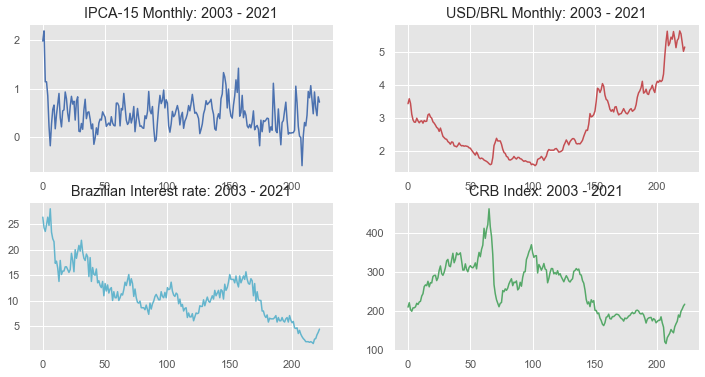

In [44]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(df2['cpi'], color = 'b')
plt.title('IPCA-15 Monthly: 2003 - 2021')

plt.subplot(2, 2, 2)
plt.plot(df2['exchange_rate'], color = 'r')
plt.title('USD/BRL Monthly: 2003 - 2021')

plt.subplot(2, 2, 3)
plt.plot(df2['interest_rate'], color = 'c')
plt.title('Brazilian Interest rate: 2003 - 2021')

plt.subplot(2, 2, 4)
plt.plot(df2['crb_index'], color = 'g')
plt.title('CRB Index: 2003 - 2021')


## **2.2 Check if series are stacionary**

In [45]:
df2.head()

,date,cpi,exchange_rate,interest_rate,crb_index
0,2003-01-01,1.98,3.44,26.38,210.61
1,2003-01-01,2.19,3.59,24.31,221.97
2,2003-01-01,1.14,3.45,23.58,204.24
3,2003-01-01,1.14,3.12,24.90,199.95
4,2003-01-01,0.85,2.95,26.38,208.64


In [46]:
df3 = df2.copy()

### **2.2.1 ADF Test (CPI)**

In [47]:
from statsmodels.tsa.stattools import adfuller
#Null hypothesis = Serie is stationary
result = adfuller(df2['cpi'])
print(f'ADF Test:{result[0]}')
print(f'p-value: {result[1]}')
print(f'Our p-value was {result[1]} > 0.05.')

ADF Test:-2.692329475988519
p-value: 0.07537503614345596
Our p-value was 0.07537503614345596 > 0.05.


In [48]:
result1 = adfuller(df2['exchange_rate'])
print(f'ADF Test:{result1[0]}')
print(f'p-value: {result1[1]}')
print(f'Our p-value was {result1[1]} > 0.05.')




ADF Test:-0.04510485610230285
p-value: 0.9546391560927899
Our p-value was 0.9546391560927899 > 0.05.


In [49]:

result2 = adfuller(df2['interest_rate'])
print(f'ADF Test:{result2[0]}')
print(f'p-value: {result2[1]}')
print(f'Our p-value was {result2[1]} > 0.05.')


ADF Test:-1.6915078005282496
p-value: 0.43549313950646484
Our p-value was 0.43549313950646484 > 0.05.


In [50]:

result3 = adfuller(df2['crb_index'])
print(f'ADF Test:{result3[0]}')
print(f'p-value: {result3[1]}')
print(f'Our p-value was {result3[1]} > 0.05.')

ADF Test:-2.1789556968976864
p-value: 0.21397178189485766
Our p-value was 0.21397178189485766 > 0.05.


### **2.2.2 KPSS**

In [51]:
# KPSS Test
from statsmodels.tsa.stattools import kpss #Null hypothesis -> series is not statacionary
def kpss_test(timeseries):
    print("Result of KPSS Test:")
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index = ['Test Statistic', 'p-value', 'Lags used']
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)"%key] = value
    print(kpss_output)

In [52]:
#KPSS test for CPI is > 0.05 reject the null hypothesis (serie is  stationary )
kpss_test(df2['cpi'])


Result of KPSS Test:
Test Statistic          0.16
p-value                 0.10
Lags used               7.00
Critical Value (10%)    0.35
Critical Value (5%)     0.46
Critical Value (2.5%)   0.57
Critical Value (1%)     0.74
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [53]:
#KPSS test for CPI is > null hypothesis (serie is  stationary )
kpss_test(df2['interest_rate'])

Result of KPSS Test:


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic          1.47
p-value                 0.01
Lags used               9.00
Critical Value (10%)    0.35
Critical Value (5%)     0.46
Critical Value (2.5%)   0.57
Critical Value (1%)     0.74
dtype: float64


In [54]:
#KPSS test for CPI is > null hypothesis (serie is  stationary )
kpss_test(df2['exchange_rate'])

Result of KPSS Test:
Test Statistic          1.31
p-value                 0.01
Lags used               9.00
Critical Value (10%)    0.35
Critical Value (5%)     0.46
Critical Value (2.5%)   0.57
Critical Value (1%)     0.74
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [56]:
#KPSS test for CPI is > null hypothesis (serie is  stationary )
kpss_test(df2['crb_index'])

Result of KPSS Test:
Test Statistic          1.30
p-value                 0.01
Lags used               9.00
Critical Value (10%)    0.35
Critical Value (5%)     0.46
Critical Value (2.5%)   0.57
Critical Value (1%)     0.74
dtype: float64


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# **2.2.3 Check autocorrelation**

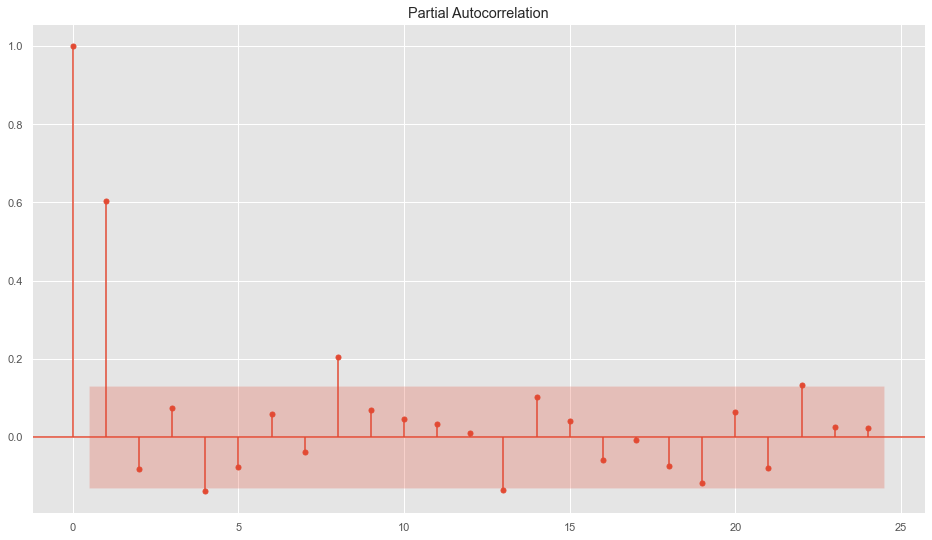

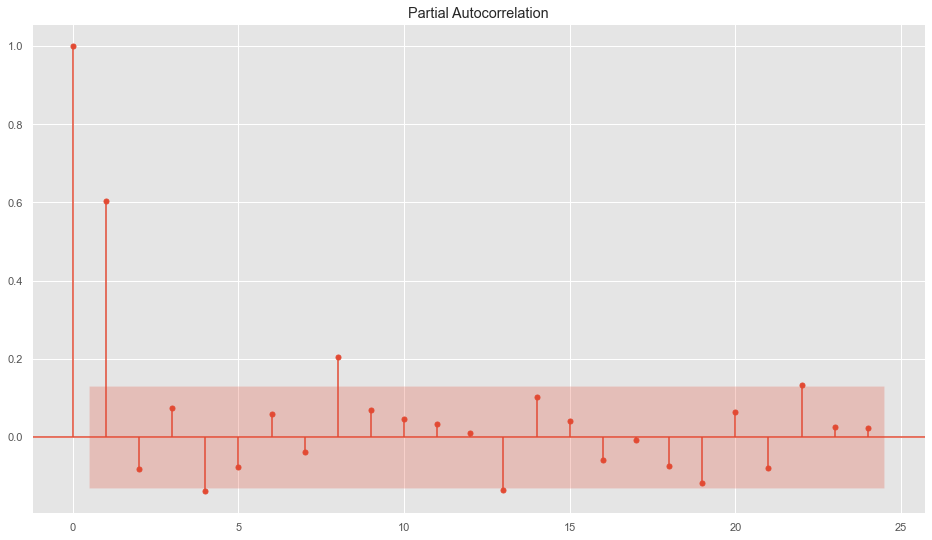

In [101]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df2['cpi'])
#plt.subplot(2, 2, 1)
#plot_pacf(df2['exchange_rate'])

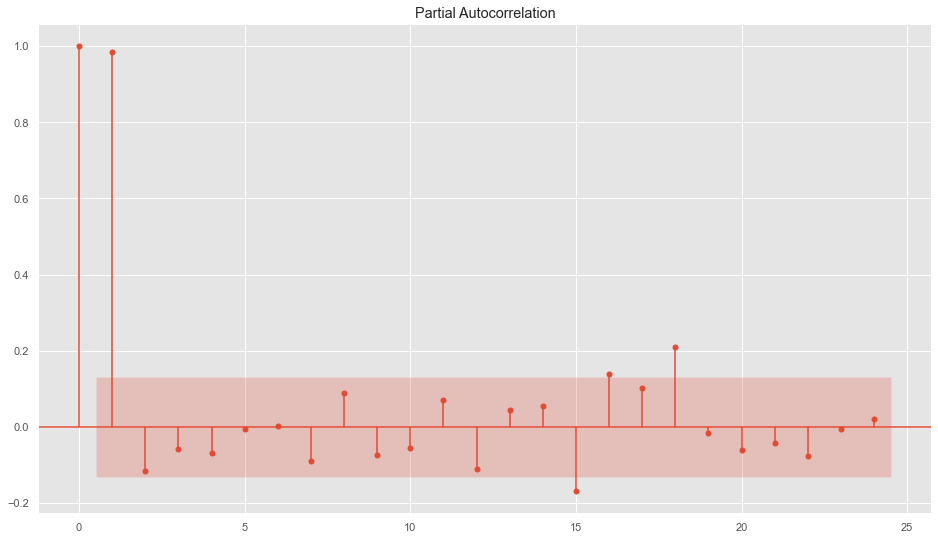

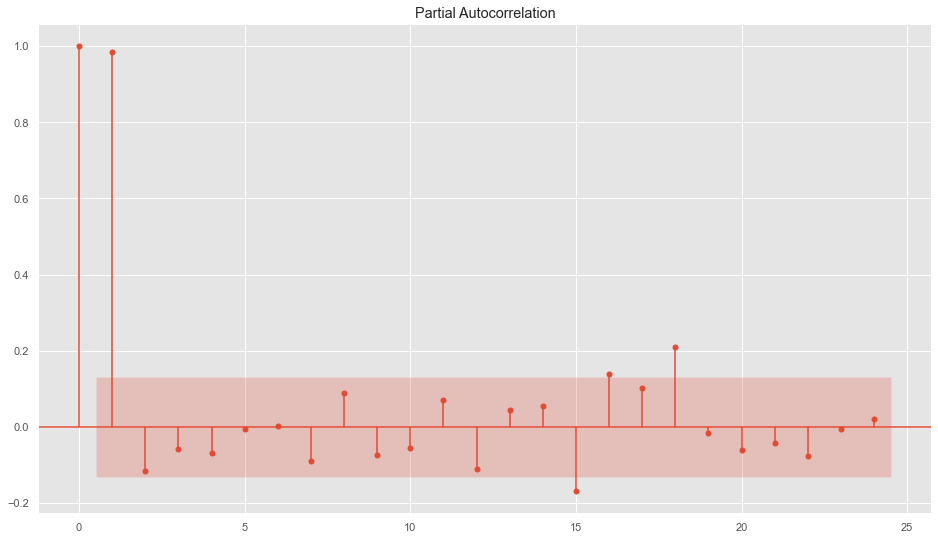

In [102]:
plot_pacf(df2['exchange_rate'])

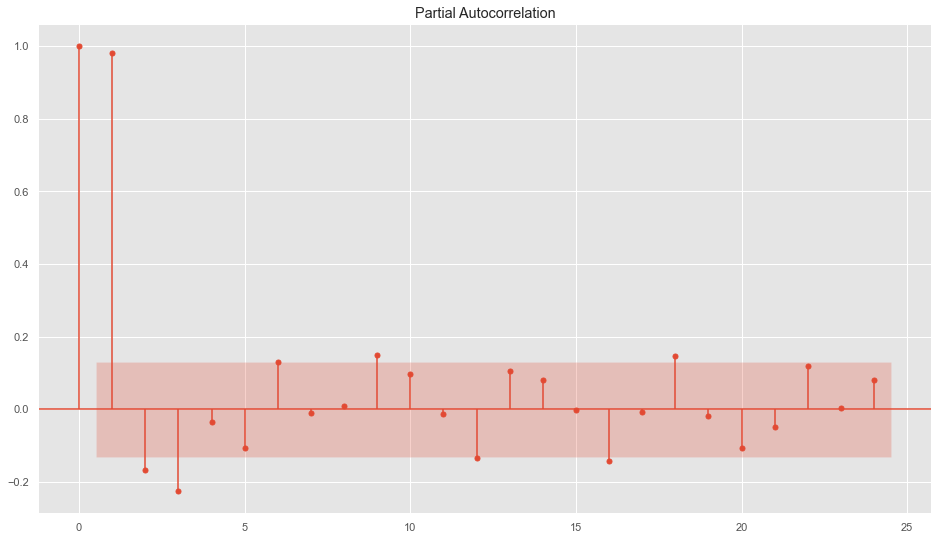

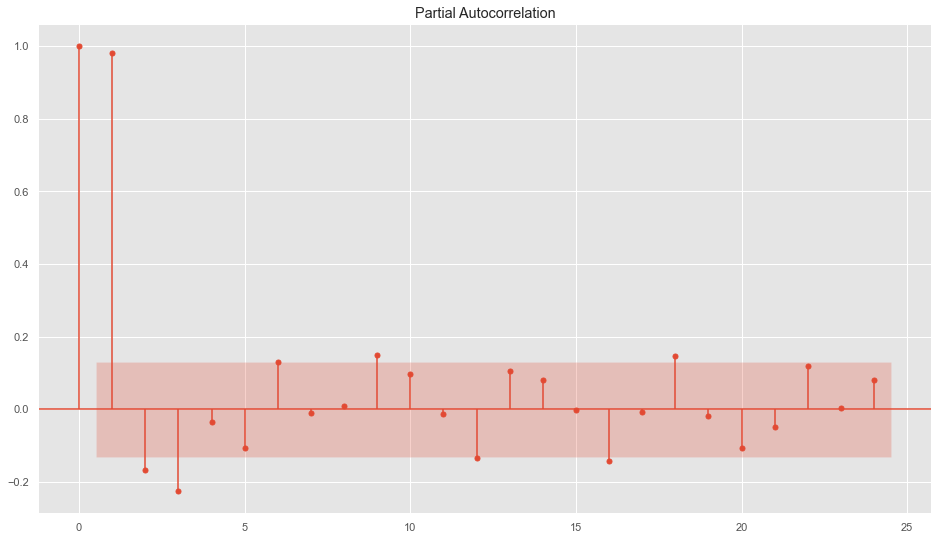

In [106]:
plot_pacf(df2['crb_index'])

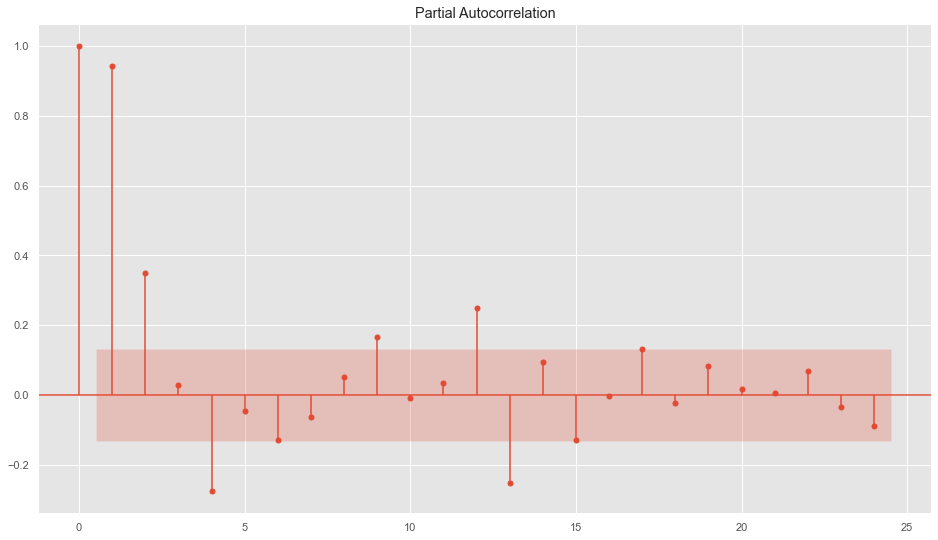

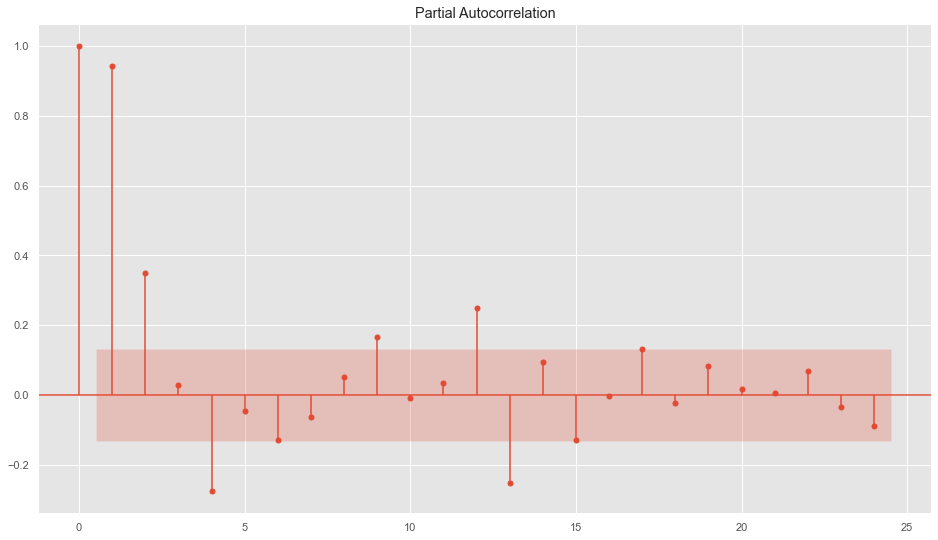

In [107]:
plot_pacf(df2['interest_rate'])

# **3.0 Diff**

In [57]:
df3 = df2.copy()

In [58]:
from statsmodels.tsa.statespace.tools import diff
df3['cpi'] = np.log(df3['cpi']).diff()
df3['exchange_rate'] = np.log(df3['exchange_rate']).diff()
df3['interest_rate'] = np.log(df3['interest_rate']).diff()
df3['crb_index'] = np.log(df3['crb_index']).diff()
df3.dropna(inplace=True)


c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'CRB Index: 2003 - 2021')

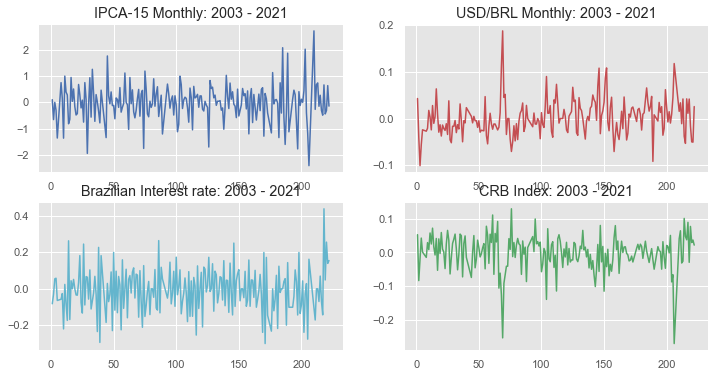

In [59]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.plot(df3['cpi'], color = 'b')
plt.title('IPCA-15 Monthly: 2003 - 2021')

plt.subplot(2, 2, 2)
plt.plot(df3['exchange_rate'], color = 'r')
plt.title('USD/BRL Monthly: 2003 - 2021')

plt.subplot(2, 2, 3)
plt.plot(df3['interest_rate'], color = 'c')
plt.title('Brazilian Interest rate: 2003 - 2021')

plt.subplot(2, 2, 4)
plt.plot(df3['crb_index'], color = 'g')
plt.title('CRB Index: 2003 - 2021')


## **3.1 ADF in Diff**

In [60]:
result1 = adfuller(df3['exchange_rate'])
print(f'ADF Test:{result1[0]}')
print(f'p-value: {result1[1]}')
#print(f'Our p-value was {result1[1]} < 0.05.')




ADF Test:-9.713128288918794
p-value: 9.992097910416985e-17


In [61]:

result2 = adfuller(df3['interest_rate'])
print(f'ADF Test:{result2[0]}')
print(f'p-value: {result2[1]}')
#print(f'Our p-value was {result2[1]} < 0.05.')


ADF Test:-4.4612448153197475
p-value: 0.00023089899660340112


In [62]:

result3 = adfuller(df3['crb_index'])
print(f'ADF Test:{result3[0]}')
print(f'p-value: {result3[1]}')
#print(f'Our p-value was {result3[1]} < 0.05.')

ADF Test:-5.902383944359276
p-value: 2.75858002389106e-07


# **4.0 Estimating VAR model**

In [74]:
df4 = df3.drop(columns='date').copy()
df4.head()

,cpi,exchange_rate,interest_rate,crb_index
1,0.10,0.04,-0.08,0.05
2,-0.65,-0.04,-0.03,-0.08
3,0.00,-0.10,0.05,-0.02
4,-0.29,-0.06,0.06,0.04
5,-1.35,-0.02,-0.06,0.00


In [75]:
df42 = df4[['cpi', 'exchange_rate', 'interest_rate', 'crb_index']].copy()

In [76]:
from statsmodels.tsa.api import VAR
# make a VAR model
model = VAR(df42)
results = model.fit(2)
results.summary()

c:\Users\victo\Music\Projetos\VAR_Forecast\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, Sep, 2021
Time:                     22:05:42
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -17.4195
Nobs:                     205.000    HQIC:                  -17.7670
Log likelihood:           717.780    FPE:                1.51875e-08
AIC:                     -18.0030    Det(Omega_mle):     1.27893e-08
--------------------------------------------------------------------
Results for equation cpi
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.029010         0.045720           -0.635           0.526
L1.cpi                  -0.309736         0.067154           -4.612           0.000
L1.exchange_rate         1.988191         1.451332